# IBSR_23:Brain Tissue Segmentation Using Deep Learning
Author(s): **Mohammad Imran Hossain, Muhammad Zain Amin**
<br>University of Girona, Spain
<br>Erasmus Mundus Joint Master Degree in Medical Imaging and Applications

# Necessary Libraries

In [7]:
# Import all the necessary libraries
import os
import cv2
import glob
import random
import tqdm 
import scipy.misc
import numpy as np
from tqdm import tqdm
import SimpleITK as sitk
from scipy import ndimage
from pathlib import Path
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Input


# Import Dataset
- **Load the train and validation dataset from the dirctory**

In [8]:
# Define the path of the train and validation dataset directory
TRAIN_DATA_PATH = Path('D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_23_Brain_Tissue_Segmentation/Dataset/Training_Set')
VALID_DATA_PATH = Path('D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_23_Brain_Tissue_Segmentation/Dataset/Validation_Set')

In [9]:
# Define a function to load image dataset from a directory
def load_data(image_size, data_path):
    """
    Load image and label data from a specified directory path.

    Args:
    - image_size : Image dimensions (depth, height, width).
    - data_path  : Path of the directory containing image and label data.

    Returns:
    - images     :  List of images.
                           Shape: (num_images, depth, height, width, channels)
    - labels     :  List of labels.
                           Shape: (num_images, depth, height, width, channels)
    """
    # Count the number of images in the data path
    num_images = len(list(data_path.iterdir()))
    
    # Initialize arrays to store images and labels
    images = np.zeros((num_images, *image_size, 1))  
    labels = np.zeros((num_images, *image_size, 1))  

    # Progress bar initialization
    with tqdm(total=num_images, desc='Loading Progress') as pbar:
        idx = 0  
        # Loop through each image in the data path
        for image_path in data_path.iterdir():
            
            # Extract the image ID and define the image path
            image_id    = image_path.name  
            image_path  = data_path / image_id / f'{image_id}.nii.gz'  
            
            # Read the image and convert into array
            image       = sitk.ReadImage(str(image_path))  
            image_array = sitk.GetArrayFromImage(image)
            image_array = image_array/np.max(image_array)
            image_array = image_array.reshape((*image_size, 1))  
            
            # Define the label path
            label_path  = data_path / image_id / f'{image_id}_seg.nii.gz' 
            
            # Read the label and convert into array
            label       = sitk.ReadImage(str(label_path))  
            label_array = sitk.GetArrayFromImage(label)  
            label_array = label_array.reshape((*image_size, 1))  

            # Insert loaded images and labels into arrays
            images[idx] = image_array
            labels[idx] = label_array
            idx += 1  
            
            pbar.update(1)  

    return (images, labels) 

# Define the image size
IMAGE_SIZE = (256, 128, 256)

# Read train and validation images and corresponding lables
(train_images, train_labels) = load_data(IMAGE_SIZE, TRAIN_DATA_PATH)
(valid_images, valid_labels) = load_data(IMAGE_SIZE, VALID_DATA_PATH)

print('Total Number of Train Image      : ', len(train_images))
print('Total Number of Validation Image : ', len(valid_images))

Loading Progress: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]

Total Number of Train Image      :  10
Total Number of Validation Image :  5


- **Display train and validation images and corresponding labels**

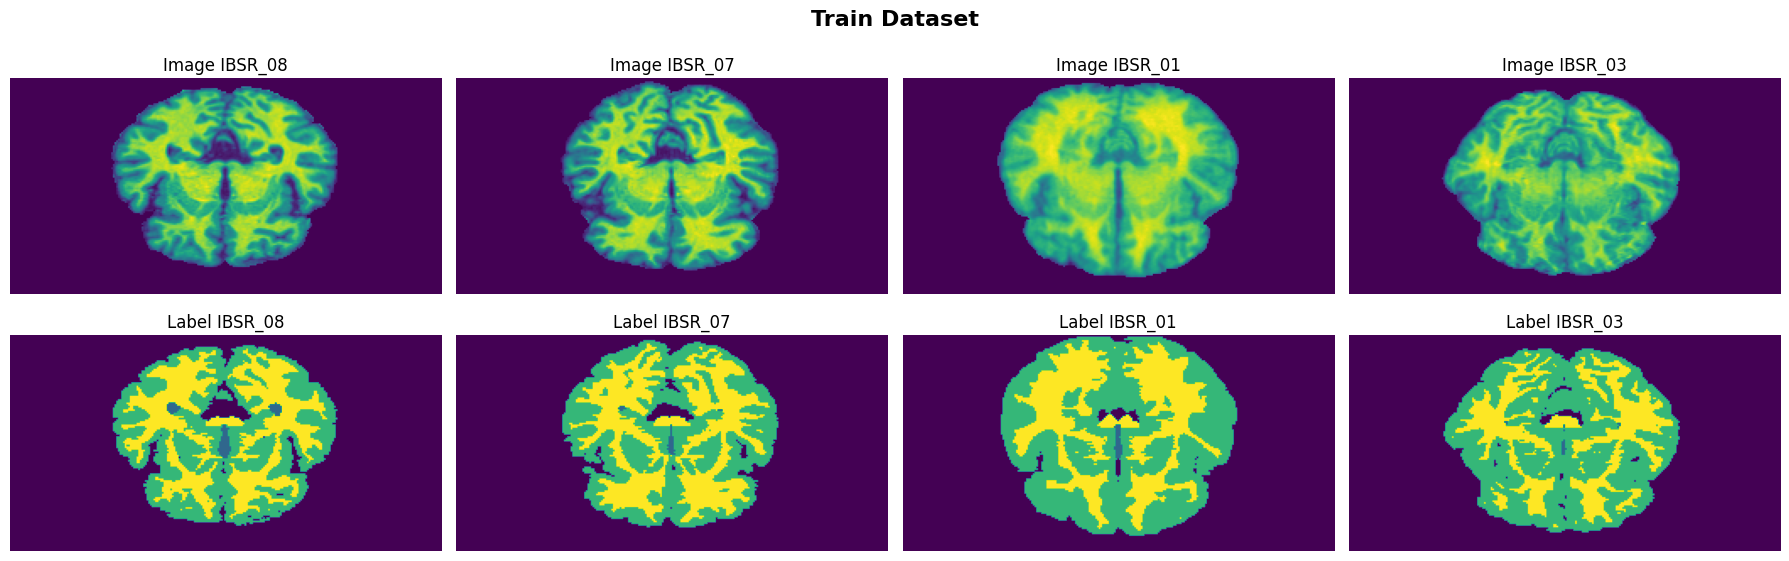

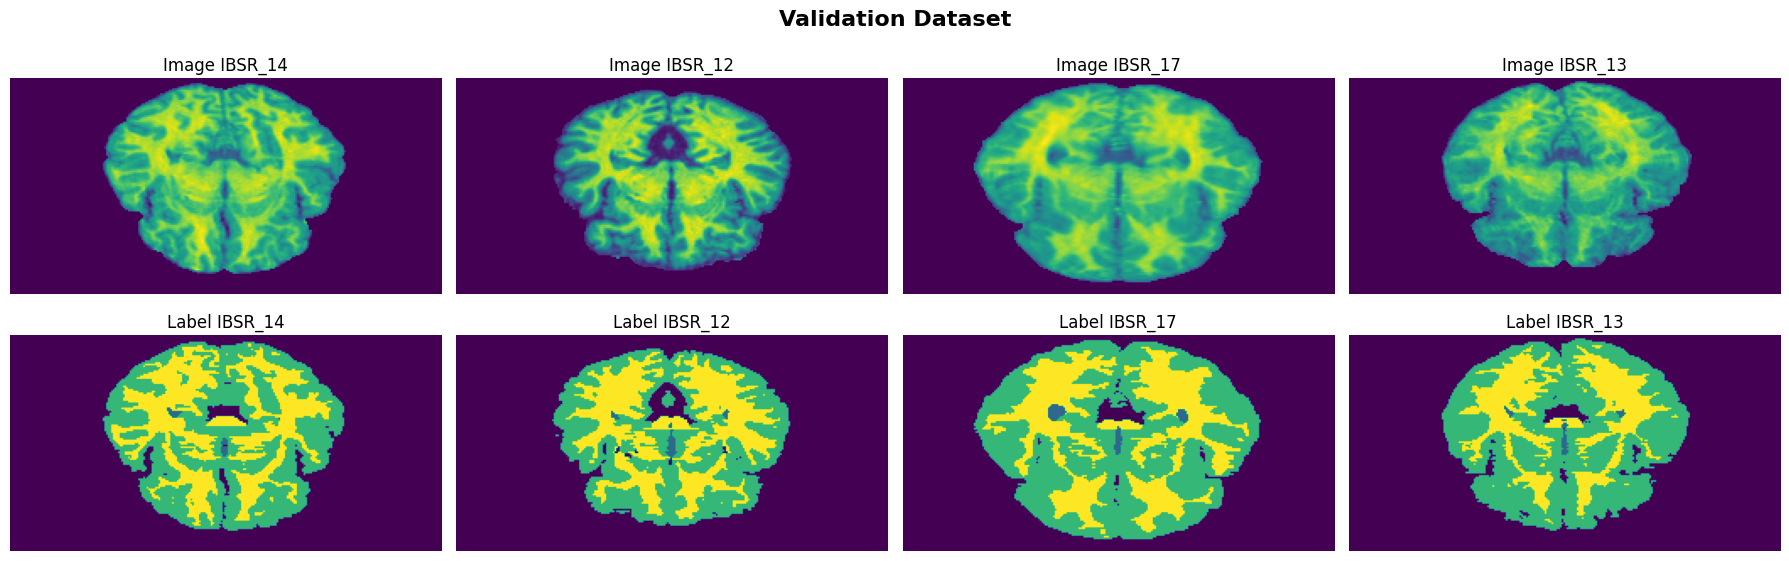

In [10]:
# Define a function to plot images and their corresponding labels
def plot_images_and_labels(images, labels, image_names, num_samples=4, dataset='Training Images'):
    """
    Plot images and their corresponding labels.

    Args:
    - images      : Array of images 
    - labels      : Array of labels 
    - image_names : List of image names or identifiers
    - num_samples : Number of samples to plot
    - dataset     : Type of Dataset
    """
    
    # Set the figure size
    plt.figure(figsize=(18, 6))
    
    # Define the slice number
    slice_num = 125

    # Select random indices for samples to plot
    random_indices = random.sample(range(len(images)), num_samples)

    # Iterate through the selected random indices
    for i, idx in enumerate(random_indices, 1):
        # Plot the image
        plt.subplot(2, num_samples, i)
        plt.imshow(images[idx, slice_num, :, :], cmap='viridis')  
        plt.title(f"Image {image_names[idx]}")  
        plt.axis('off')  

        # Plot the label
        plt.subplot(2, num_samples, i + num_samples)
        plt.imshow(labels[idx, slice_num, :, :], cmap='viridis')  
        plt.title(f"Label {image_names[idx]}")  
        plt.axis('off')  

    # Set a super title for the entire plot
    plt.suptitle(dataset, fontsize=16, fontweight='bold')
    plt.tight_layout()  
    plt.show()  


# Plot train images and corresponding labels
train_image_names = os.listdir(TRAIN_DATA_PATH)
plot_images_and_labels(train_images, train_labels, train_image_names, dataset='Train Dataset')

# Plot validation images and corresponding labels
valid_image_names = os.listdir(VALID_DATA_PATH)
plot_images_and_labels(valid_images, valid_labels, valid_image_names, dataset='Validation Dataset')

# Data Pre-processing
- **Split train dataset into training and training-validation for deep learning model**

In [11]:
# Split train dataset into training and validation (80:20)
training_images   = train_images[:8]
training_labels   = train_labels[:8]

validation_images = train_images[-2:]
validation_labels = train_labels[-2:]

print('Total Number of Training Image            :', len(training_images))
print('Total Number of Training-Validation Image :', len(validation_images))

Total Number of Training Image            : 8
Total Number of Training-Validation Image : 2


- **Extract patches from both the training and traininng-validation images and corresponding labels**

In [17]:
# Define required parameters for patch extraction
IMAGE_SIZE        = (256, 128, 256)  
PATCH_SIZE        = (32, 32)         
PATCH_STRIDE      = (32, 32)         
BATCH_SIZE        = 64              
N_CLASSES         = 4                
N_INPUT_CHANNELS  = 1                
CONTENT_THRESHOLD = 0.3    
dropout_rate = 0.40

# Define a function to extract patches from images and labels
def extract_patches(images, 
                    labels, 
                    image_size  = IMAGE_SIZE, 
                    patch_size  = PATCH_SIZE, 
                    stride      = PATCH_STRIDE, 
                    threshold   = CONTENT_THRESHOLD, 
                    num_classes = N_CLASSES):
    
    """
    Extracts patches from input images and labels.

    Args:
    - images     : Input images.
    - labels     : Corresponding labels for the input images.
    - image_size : Dimensions of the input images (slice, height, width).
    - patch_size : Dimensions of the patches to be extracted (height, width).
    - stride     : Dimensions of the stride for patch extraction (vertical stride, horizontal stride).
    - threshold  : Threshold value to determine the usefulness of extracted patches.
    - num_classes: Number of classes in the dataset.

    Returns:
    - useful_image_patches: Extracted patches from input images.
    - useful_label_patches: Extracted patches from labels of the corresponding input images.
    """

    # Reshape images and labels for patch extraction
    images_reshaped = images.reshape([-1, image_size[1], image_size[2], 1])
    labels_reshaped = labels.reshape([-1, image_size[1], image_size[2], 1])

    # Extract patches from images
    image_patches = tf.image.extract_patches(
        images_reshaped,
        sizes   = [1, patch_size[0], patch_size[1], 1],
        strides = [1, stride[0], stride[1], 1],
        rates   = [1, 1, 1, 1],
        padding = 'SAME'
    ).numpy()

    # Extract patches from labels
    label_patches = tf.image.extract_patches(
        labels_reshaped,
        sizes   = [1, patch_size[0], patch_size[1], 1],
        strides = [1, stride[0], stride[1], 1],
        rates   = [1, 1, 1, 1],
        padding = 'SAME'
    ).numpy()

    # Reshape patches for further processing
    image_patches = image_patches.reshape([-1, *patch_size, 1])
    label_patches = label_patches.reshape([-1, *patch_size])

    # Masking to retain only foreground patches
    foreground_mask = label_patches != 0
    patch_product   = np.prod(patch_size)

    # Check for useful patches based on the threshold
    useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * patch_product

    # Filter patches based on usefulness
    useful_image_patches = image_patches[useful_patches]
    useful_label_patches = label_patches[useful_patches]

    # Convert label patches to one-hot encoded format
    useful_label_patches = tf.keras.utils.to_categorical(useful_label_patches, num_classes=num_classes, dtype='float32')

    return useful_image_patches, useful_label_patches

# Extract patches from training and validation images along with their corresponding labels
(training_image_patches, training_label_patches)     = extract_patches(training_images, training_labels)
(validation_image_patches, validation_label_patches) = extract_patches(validation_images, validation_labels)

print('Total Number of Patches from Training Images   : ', len(training_image_patches))
print('Total Number of Patches from Validation Images : ', len(validation_image_patches))

Total Number of Patches from Training Images   :  9088
Total Number of Patches from Validation Images :  3700


- **Display some random patches for the vizualization**

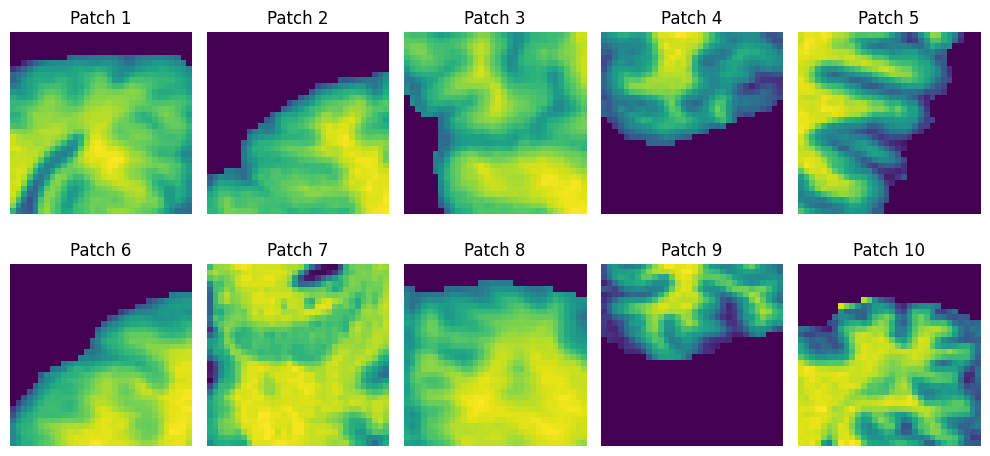

In [18]:
# Define the number of patches to plot
num_patches = 10

# Randomly select patches to plot
random_indices = np.random.choice(len(training_image_patches), num_patches, replace=False)

# Create a figure to plot the patches
plt.figure(figsize=(10, 5))

# Loop through each patch to plot
for i in range(num_patches):
    plt.subplot(2, 5, i + 1)  
    patch_index   = random_indices[i]  
    patch_to_plot = training_image_patches[patch_index]  
    plt.imshow(patch_to_plot, cmap='viridis')  
    plt.axis('off')  
    plt.title(f'Patch {i+1}')  

plt.tight_layout()  
plt.show()  

# Data Augmentation
- **Augment the training and training-validation dataset to handle data imbalance**

In [19]:
# Degree of Augmentation
DEGREE = 0.2

# Create the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range     = 40,            
    width_shift_range  = DEGREE,    
    height_shift_range = DEGREE,                
    shear_range        = DEGREE,          
    zoom_range         = DEGREE,            
    horizontal_flip    = True,        
    vertical_flip      = True,           
    fill_mode          ='nearest'  # fill_mode options: 'constant', 'nearest', 'reflect', 'wrap'
   
)

# Generate augmented training data and labels 
train_generator = datagen.flow(
    training_image_patches,
    batch_size=int(training_image_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

train_label_generator = datagen.flow(
    training_label_patches,
    batch_size=int(training_label_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

# Generate augmented training-validation data and labels 
validation_generator = datagen.flow(
    validation_image_patches,
    batch_size=int(validation_image_patches.shape[0] / BATCH_SIZE),  
    seed=1 
)

validation_label_generator = datagen.flow(
    validation_label_patches,
    batch_size=int(validation_label_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

In [20]:
# Retrieve batches of augmented data from the generators
X_train = train_generator.next()  
Y_train = train_label_generator.next()  

# Concatenate original and augmented data for the training set
total_train_images = np.concatenate((training_image_patches, X_train))
total_train_labels = np.concatenate((training_label_patches, Y_train))

# Retrieve batches of augmented data for the validation set
X_validation = validation_generator.next()  
Y_validation = validation_label_generator.next()  

# Concatenate original and augmented data for the validation set
total_validation_images = np.concatenate((validation_image_patches, X_validation))
total_validation_labels = np.concatenate((validation_label_patches, Y_validation))

# Display shapes of the datasets
print('---------Training Dataset----------')
print('Shape of Image Patches:', total_train_images.shape)
print('Shape of Label Patches:', total_train_labels.shape)

print('\n---------Validation Dataset----------')
print('Shape of Image Patches:', total_validation_images.shape)
print('Shape of Label Patches:', total_validation_labels.shape)


---------Training Dataset----------
Shape of Image Patches: (9230, 32, 32, 1)
Shape of Label Patches: (9230, 32, 32, 4)

---------Validation Dataset----------
Shape of Image Patches: (3757, 32, 32, 1)
Shape of Label Patches: (3757, 32, 32, 4)


# DenseU-Net Model

In [21]:
# Define DenseU-Net model architecture
def get_DenseUnet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding Path of the DenseUNet (32-64-128-256-512)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conc11 = concatenate([inputs, conv11], axis=3)
    conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=3)
    drop1 = Dropout(rate=dropout_rate)(conc12, training=True)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv21 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=3)
    conv22 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=3)
    drop2 = Dropout(rate=dropout_rate)(conc22, training=True)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv31 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=3)
    conv32 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=3)
    drop3 = Dropout(rate=dropout_rate)(conc32, training=True)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv41 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=3)
    conv42 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=3)
    drop4 = Dropout(rate=dropout_rate)(conc42, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv51 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conc51 = concatenate([pool4, conv51], axis=3)
    conv52 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=3)
    drop5 = Dropout(rate=dropout_rate)(conc52, training=True)

    # Decoding Path of the ResUNet
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop5), conc42], axis=3)
    conv61 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=3)
    conv62 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=3)
    drop6 = Dropout(rate=dropout_rate)(conc62, training=True)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(drop6), conv32], axis=3)
    conv71 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=3)
    conv72 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=3)
    drop7 = Dropout(rate=dropout_rate)(conc72, training=True)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop7), conv22], axis=3)
    conv81 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=3)
    conv82 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=3)
    drop8 = Dropout(rate=dropout_rate)(conc82, training=True)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(drop8), conv12], axis=3)
    conv91 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=3)
    conv92 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=3)
    drop9 = Dropout(rate=dropout_rate)(conc92, training=True)

    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(drop9)

    model = Model(inputs, outputs)

    return model

# Create an instance of the model
DenseUnet_model = get_DenseUnet()

# Display model summary
DenseUnet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 32, 32, 32)           320       ['input_2[0][0]']             
                                                                                                  
 concatenate_2 (Concatenate  (None, 32, 32, 33)           0         ['input_2[0][0]',             
 )                                                                   'conv2d_2[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 32)           9536      ['concatenate_2[0][0]']  

# ResU-Net Model

In [ ]:
def get_ResUnet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding Path of the ResUNet (32-64-128-256-512)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conc1 = concatenate([inputs, conv1], axis=3)
    drop1 = Dropout(rate=dropout_rate)(conc1, training=True)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conc2 = concatenate([pool1, conv2], axis=3)
    drop2 = Dropout(rate=dropout_rate)(conc2, training=True)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conc3 = concatenate([pool2, conv3], axis=3)
    drop3 = Dropout(rate=dropout_rate)(conc3, training=True)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conc4 = concatenate([pool3, conv4], axis=3)
    drop4 = Dropout(rate=dropout_rate)(conc4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conc5 = concatenate([pool4, conv5], axis=3)
    drop5 = Dropout(rate=dropout_rate)(conc5, training=True)

    # Decoding Path of the ResUNet
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conc6 = concatenate([up6, conv6], axis=3)
    drop6 = Dropout(rate=dropout_rate)(conc6, training=True)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(drop6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conc7 = concatenate([up7, conv7], axis=3)
    drop7 = Dropout(rate=dropout_rate)(conc7, training=True)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conc8 = concatenate([up8, conv8], axis=3)
    drop8 = Dropout(rate=dropout_rate)(conc8, training=True)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(drop8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conc9 = concatenate([up9, conv9], axis=3)
    drop9 = Dropout(rate=dropout_rate)(conc9, training=True)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(drop9)

    model = Model(inputs, outputs)

    return model

# Create an instance of the model
ResUnet_model = get_ResUnet()

# Display model summary
ResUnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 32, 32, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_22 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_21[0][0]']           
                                                                                                  
 concatenate_24 (Concatenat  (None, 32, 32, 33)           0         ['input_3[0][0]',             
 e)                                                                  'conv2d_22[0][0]']     

# Train Model
- **Train the DenseU-Net Model**

In [115]:
# Define training parameters
N_EPOCHS     = 200
BATCH_SIZE   = 64
PATIENCE     = 20
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMIZER    = 'Adam'
LOSS         = 'categorical_crossentropy'
dropout_rate = 0.40

# Create the callback list with earlystopping and model checkpoint
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE), 
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True)]

# Compile the DenseUnet model
DenseUnet_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])

# Train the DenseUnet model
history = DenseUnet_model.fit(
    x               = total_train_images, 
    y               = total_train_labels,
    validation_data = (total_validation_images, total_validation_labels),
    batch_size      = BATCH_SIZE,
    epochs          = N_EPOCHS,
    callbacks       = my_callbacks,
    verbose         = 1)

Epoch 1/200
145/145 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.7654

C:\Users\hossa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


145/145 [==============================] - 288s 2s/step - loss: 0.5403 - accuracy: 0.7654 - val_loss: 0.4275 - val_accuracy: 0.8338
Epoch 2/200
145/145 [==============================] - 273s 2s/step - loss: 0.3480 - accuracy: 0.8638 - val_loss: 0.3075 - val_accuracy: 0.8820
Epoch 3/200
145/145 [==============================] - 271s 2s/step - loss: 0.2798 - accuracy: 0.8909 - val_loss: 0.2747 - val_accuracy: 0.8983
Epoch 4/200
145/145 [==============================] - 270s 2s/step - loss: 0.2375 - accuracy: 0.9072 - val_loss: 0.2814 - val_accuracy: 0.9004
Epoch 5/200
145/145 [==============================] - 276s 2s/step - loss: 0.2143 - accuracy: 0.9158 - val_loss: 0.2530 - val_accuracy: 0.9048
Epoch 6/200
145/145 [==============================] - 276s 2s/step - loss: 0.1951 - accuracy: 0.9233 - val_loss: 0.2609 - val_accuracy: 0.9046
Epoch 7/200
145/145 [==============================] - 271s 2s/step - loss: 0.1846 - accuracy: 0.9270 - val_loss: 0.2618 - val_accuracy: 0.9077
Epoc

In [116]:
# Creating an instance of the DenseU-Net model with specific configurations
DenseUnet_model = get_DenseUnet(img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
                                n_classes=N_CLASSES,
                                n_input_channels=N_INPUT_CHANNELS)

# Compiling the model with an optimizer and loss function for training
DenseUnet_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])

# Loading pre-trained weights into the model from a saved file
DenseUnet_model.load_weights('model.h5')

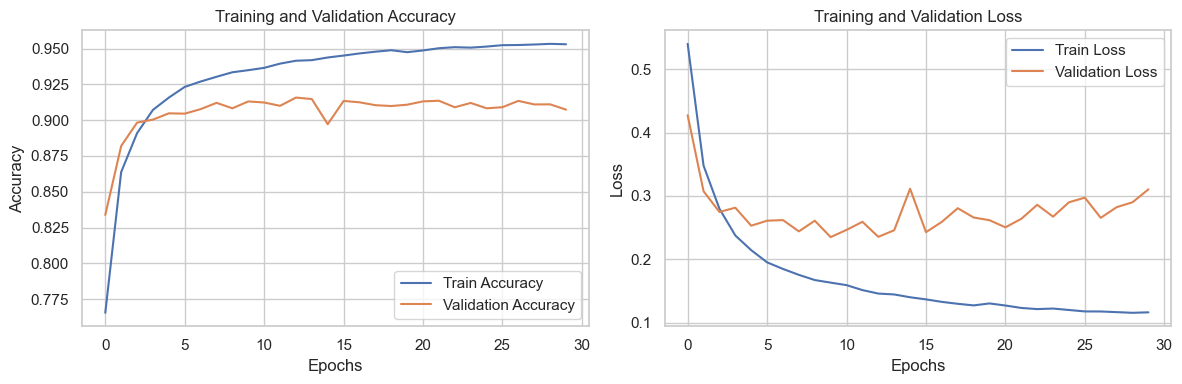

In [117]:
# Plotting training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test Prediction
- **Prepare the validation that for making the prediction using the trained models**

In [132]:
# Define a function to prepare validation data for prediction using the trained model
def prepare_valid_data(valid_images, valid_labels):
    """
    Prepare validation data for prediction by reshaping images and labels.

    Args:
    - valid_images : Validation images data.
    - valid_labels : Validation labels data.

    Returns:
    - valid_images_reshaped: Reshaped validation images.
    - valid_labels_modified: Modified validation labels.
    """
    
    # Reshape the valid images and labels to match the required input shape for the model
    valid_images_reshaped = valid_images.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
    valid_labels_reshaped = valid_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
    
    # Modify the validation labels to categorical format suitable for model prediction
    valid_labels_modified = tf.keras.utils.to_categorical(valid_labels_reshaped, num_classes=4, dtype='float32')
    
    return valid_images_reshaped, valid_labels_modified


- **Predict the validation dataset using trained DenseUNet Model**

In [133]:
# Define lists to store processed validation labels and validation predictions 
valid_processed_labels = []  
valid_predictions      = []       

# Iterate through each validation image and label
for i in range(len(valid_images)):
    
    # Prepare the individual validation image and label for the prediction using trained model
    pre_valid_image, pre_valid_label = prepare_valid_data(valid_images[i], valid_labels[i])
    
    # Get predictions using the trained DenseU-Net model for the prepared validation image
    prediction = DenseUnet_model.predict(x=pre_valid_image)
    
    # Transform the prediction to obtain the predicted class indices
    prediction = np.argmax(prediction, axis=3)
    
    # Append the predicted labels and processed validation labels to their respective lists
    valid_predictions.append(prediction)
    valid_processed_labels.append(pre_valid_label)


8/8 [==============================] - 28s 4s/step


- **Map the prediction result to each class (background, CSF, WM, GM)**

In [134]:
# Define list to store processed predictions
valid_processed_predictions = []  

# Function to map predicted values to separate channels for each class
def map_predictions_to_channels(predictions):
    """
    Map predicted values to separate channels for each class.

    Args:
    - predictions      : Predicted values.

    Returns:
    - final_prediction : Prediction result.
    """
    # Create empty arrays for each class based on predictions
    background = np.where(predictions == 0, 1, 0)          # Set background values to 1, others to 0
    csf        = np.where(predictions == 1, 1, 0)          # Set CSF values to 1, others to 0
    wm         = np.where(predictions == 2, 1, 0)          # Set WM values to 1, others to 0
    gm         = np.where(predictions == 3, 1, 0)          # Set GM values to 1, others to 0
    
    # Stack the channels together to create a 4-channel prediction result
    final_prediction = np.stack([background, csf, wm, gm], axis=-1)
    
    return final_prediction.astype(np.float32) 


for i in range(len(valid_images)):
    
    # Convert current predictions to match the desired format using the mapping function
    valid_processed_prediction = map_predictions_to_channels(valid_predictions[i])
    valid_processed_predictions.append(valid_processed_prediction)


In [135]:
print('Shape of the predictions: ',valid_processed_predictions[1].shape)
print('Shape of the labels     : ',valid_processed_labels[1].shape)

Shape of the predictions:  (256, 128, 256, 4)
Shape of the labels     :  (256, 128, 256, 4)


- **Display some random segmentation result with their corresponding groundtruth**

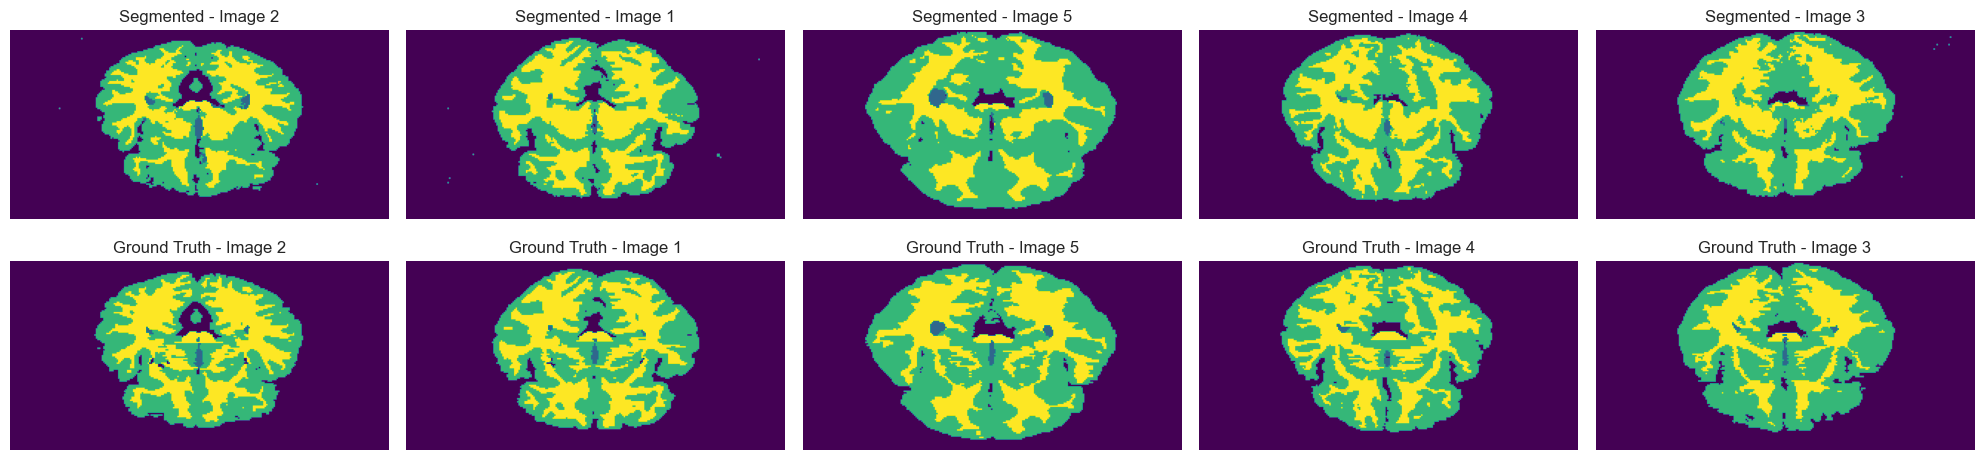

In [136]:
# Select 5 random indices for images to plot
indices = random.sample(range(len(valid_processed_labels)), 5)

# Plot the images
plt.figure(figsize=(20, 5))

for i, index in enumerate(indices, 1):
    
    # Plot segmented images
    plt.subplot(2, 5, i)
    plt.imshow(valid_processed_predictions[index][125,:,:,:].argmax(axis=-1), cmap='viridis')  
    plt.title(f'Segmented - Image {index + 1}')
    plt.axis('off')
    
    # Plot groundtruth 
    plt.subplot(2, 5, i + 5)
    plt.imshow(valid_labels[index][125,:,:,:], cmap='viridis')  
    plt.title(f'Ground Truth - Image {index + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Performance Evaluation

In [137]:
def dice_score(prediction, ground_truth):
    """
    Calculate Dice coefficients for each class between prediction and ground truth.

    Args:
    - prediction    : Predicted values.
    - ground_truth  : Ground truth values.

    Returns:
    - scores        : List containing Dice coefficients for each class.
    """
    
    # Define list to store Dice coefficients for each class
    scores = []  
    
    for i in range(N_CLASSES):
        
        # Seperate class channels
        prediction_each_class = prediction[:, :, :, i]
        ground_truth_each_class = ground_truth[:, :, :, i]

        # Flatten the images to 1D arrays
        prediction_flat = prediction_each_class.flatten()
        ground_truth_flat = ground_truth_each_class.flatten()

        # Calculate intersection, union, and Dice coefficient
        intersection = np.sum(prediction_flat * ground_truth_flat)
        union = np.sum(prediction_flat) + np.sum(ground_truth_flat)
        score = (2.0 * intersection) / (union + 1e-8)  
        scores.append(score)
        
    return scores

In [138]:
# Define list to store Dice coefficients for each image
dice_scores = []  

# Iterate over segemented images to compute dice score
for i in range(len(valid_processed_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    dice_coeff = dice_score(valid_processed_predictions[i], valid_processed_labels[i])
    dice_scores.append(dice_coeff)

# Create a Pandas DataFrame to display the Dice coefficients
dice_scores_df = pd.DataFrame(dice_scores)
dice_scores_df.columns = ['Background', 'CSF', 'WM', 'GM']  
dice_scores_df

,Background,CSF,WM,GM
0,0.997070,0.681443,0.903266,0.917521
1,0.996321,0.734346,0.877999,0.860638
2,0.995909,0.725516,0.880755,0.834121
3,0.996529,0.827355,0.913775,0.908579
4,0.995769,0.820326,0.908319,0.825615


In [139]:
# Calculate mean and standard deviation for each class
means    = dice_scores_df.mean()
std_devs = dice_scores_df.std()

# Display the calculated mean and standard deviation for each class
print("Mean for each class:")
print(means)
print("\nStandard deviation for each class:")
print(std_devs)

Mean for each class:
Background    0.996320
CSF           0.757797
WM            0.896823
GM            0.869295
dtype: float64

Standard deviation for each class:
Background    0.000519
CSF           0.063581
WM            0.016383
GM            0.042098
dtype: float64
